In [3]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
from collections import defaultdict

from src.preprocess import split_improvements, parse_improvement, clean_text
from src.labels import labels_measure

# --- CONFIG ---
FILE = "../data/raw/D_EPC_data_2025Q2/2015Q3.csv"  # change to your file
ID_COL = "REPORT_REFERENCE_NUMBER"  # aka RRN
TEXT_COL = "IMPROVEMENTS"
META_COLS = [
    "POSTCODE", "CURRENT_ENERGY_RATING", "POTENTIAL_ENERGY_RATING",
    "CURRENT_ENERGY_EFFICIENCY", "POTENTIAL_ENERGY_EFFICIENCY"
]

# --- ACCUMULATORS ---
prop_texts   = defaultdict(list)   # RRN -> list of measure texts
prop_labels  = defaultdict(set)    # RRN -> set of labels
prop_meta    = {}                  # RRN -> dict of a few meta fields (first non-null seen)

# --- CHUNKED PASS ---
for chunk in pd.read_csv(FILE, chunksize=50_000, low_memory=False):
    # keep only columns we need
    use = [ID_COL, TEXT_COL] + [c for c in META_COLS if c in chunk.columns]
    chunk = chunk[use]

    # iterate rows with improvements
    for RRN, imp_text, *meta_vals in chunk[[ID_COL, TEXT_COL] + [c for c in META_COLS if c in chunk.columns]].itertuples(index=False, name=None):
        if pd.isna(imp_text):
            continue

        # store first non-null metadata for this RRN
        if RRN not in prop_meta:
            prop_meta[RRN] = dict(zip([c for c in META_COLS if c in chunk.columns], meta_vals))

        # split into individual improvement clauses
        for seg in split_improvements(imp_text):
            rec = parse_improvement(seg)
            m = rec.get("measure")
            if not m:
                continue

            prop_texts[RRN].append(m)
            for lab in labels_measure(m):
                prop_labels[RRN].add(lab)

# --- BUILD PROPERTY-LEVEL DF ---
rows = []
for RRN, measures in prop_texts.items():
    labels = sorted(list(prop_labels[RRN]))
    if not labels:
        continue  # skip properties where we found no labels
    text_doc = " . ".join(measures)
    row = {
        ID_COL: RRN,
        "text_raw": text_doc,
        "labels": labels,
        "n_measures": len(measures)
    }
    # attach metadata (if any)
    if RRN in prop_meta:
        row.update(prop_meta[RRN])
    rows.append(row)

prop_df = pd.DataFrame(rows)
prop_df["text_clean"] = prop_df["text_raw"].map(clean_text)

print(prop_df.shape)
prop_df.head(3)


(26581, 10)


,REPORT_REFERENCE_NUMBER,text_raw,labels,n_measures,POSTCODE,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,text_clean
0,0120-2329-6030-9075-1045,"Solar photovoltaic panels, 2.5 kWp . Replace b...","[heating, insulation, lighting, renewables]",6,PA5 8SU,F,D,31,68,solar photovoltaic panels kwp replace boiler n...
1,1315-5023-2000-0479-0902,Room-in-roof insulation . Internal or external...,"[glazing, heating, insulation, lighting, renew...",7,AB11 7UR,D,B,58,84,room roof insulation internal external wall in...
2,2015-6028-9000-0234-0902,Replace boiler with new condensing boiler . So...,"[heating, hot_water, insulation, lighting, ren...",8,KY4 0LT,D,B,57,87,replace boiler new condensing boiler solar wat...


In [4]:
prop_df["n_labels"] = prop_df["labels"].map(len)
prop_df["n_labels"].value_counts().sort_index()


n_labels
1    4222
2    5010
3    7788
4    6587
5    2636
6     338
Name: count, dtype: int64

Classes: ['glazing', 'heating', 'hot_water', 'insulation', 'lighting', 'renewables']
Hamming loss: 0.000940379913485048
Jaccard (samples): 0.9984232963450568
              precision    recall  f1-score   support

     glazing       1.00      1.00      1.00      1136
     heating       1.00      1.00      1.00      2858
   hot_water       1.00      1.00      1.00       722
  insulation       1.00      1.00      1.00      4021
    lighting       1.00      1.00      1.00      3870
  renewables       1.00      1.00      1.00      3363

   micro avg       1.00      1.00      1.00     15970
   macro avg       1.00      1.00      1.00     15970
weighted avg       1.00      1.00      1.00     15970
 samples avg       1.00      1.00      1.00     15970



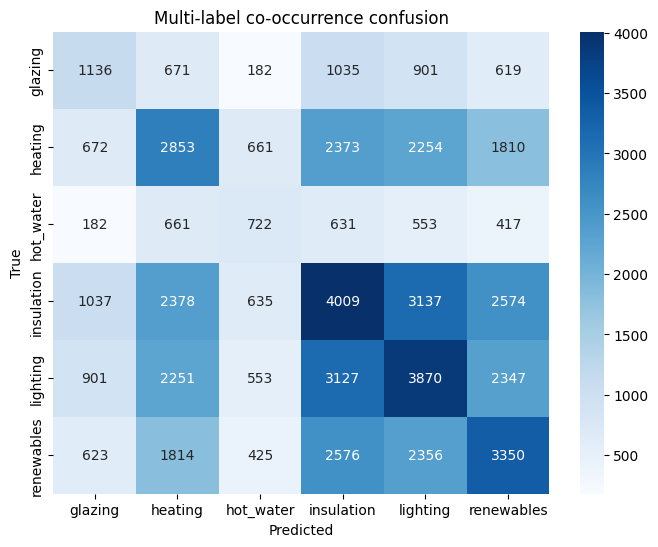

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, jaccard_score, hamming_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(prop_df["labels"])
X = prop_df["text_clean"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20_000, ngram_range=(1,2))),
    ("ovr", OneVsRestClassifier(LogisticRegression(max_iter=400, class_weight="balanced")))
])

clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print("Classes:", list(mlb.classes_))
print("Hamming loss:", hamming_loss(Y_test, Y_pred))
print("Jaccard (samples):", jaccard_score(Y_test, Y_pred, average="samples"))
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_, zero_division=0))


# build co-occurrence counts: true label vs predicted label
classes = mlb.classes_
cooc = np.zeros((len(classes), len(classes)), dtype=int)

for yt, yp in zip(Y_test, Y_pred):
    true_labels = np.where(yt==1)[0]
    pred_labels = np.where(yp==1)[0]
    for t in true_labels:
        for p in pred_labels:
            cooc[t, p] += 1

plt.figure(figsize=(8,6))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Multi-label co-occurrence confusion")
plt.show()